In [1]:
import os, sys
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
#from mitequinox.binary import *
import mitequinox.parcels as pa
from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4221371.datarmor0/parcels-502090/libparcels_random_54de30a2-eabd-4d14-9a70-53951da75531.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=7, cores=7)
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.32:38220 Dashboard: http://10.148.1.32:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import pyinterp

mesh = pyinterp.RTree()

In [6]:
grd = load_grd(V=['XC','YC'])
ds = load_data(['SSU','SSV'])
ds = xr.merge([grd,ds])

print('\n data size (all faces): %.1f GB' %(ds['SSU'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['SSU'].isel(face=1).nbytes / 1e9))
ds


 data size (all faces): 8525.4 GB

 data size (1 face): 655.8 GB


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8785)
Coordinates:
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [7]:
ds = ds.sel(face=1)
sli = slice(0,None,10) # required to make worldwide plots, otherwise, half the globe is plotted
ds = ds.isel(i=sli, j=sli, i_g=sli, j_g=sli)
#ds = ds.drop('dtime') # tmp leads to serialization issue at plots
#
ds = ds.persist()
#
print(ds)
print('\n dataset size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (i: 432, i_g: 432, j: 432, j_g: 432, time: 8785)
Coordinates:
    XC       (j, i) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
  * i        (i) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
  * j        (j) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
    face     int64 1
  * i_g      (i_g) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * j_g      (j_g) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
Data variables:
    SSU      (time, j, i_g) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    SSV      (time, j_g, i) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

 dataset size: 13.1 GB


In [8]:
lons = ds["XC"]#.isel(i=sli, j=sli)
lats = ds["YC"]#.isel(i=sli, j=sli)

In [9]:
var_mean = ds.SSV.mean('time').persist()

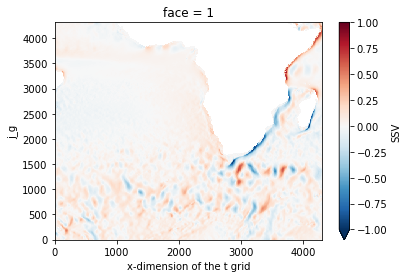

In [10]:
var_mean.plot(vmax=1)

In [11]:
mesh.packing(
    np.vstack((lons.values.flatten(), lats.values.flatten())).T,
    var_mean.values.flatten())

In [69]:
lons.values.min()

-37.989582

In [12]:
x0, x1 = -30, -20
y0, y1 = -55, -30
res = 1 / 32.0
mx, my = np.meshgrid(np.arange(x0, x1, res),
                        np.arange(y0, y1, res),
                        indexing="ij")

In [13]:
idw_eta, neighbors = mesh.inverse_distance_weighting(
    np.vstack((mx.flatten(), my.flatten())).T,
    within=True,  # Extrapolation is forbidden
    radius=55000,  # In a radius of 5.5 Km
    k=8,  # We are looking for at most 8 neighbours
    num_threads=0)
idw_eta = idw_eta.reshape(mx.shape)

In [14]:
rbf_eta, neighbors = mesh.radial_basis_function(
    np.vstack((mx.flatten(), my.flatten())).T,
    within=True,  # Extrapolation is forbidden
    k=11,  # We are looking for at most 11 neighbours
    num_threads=0)
rbf_eta = rbf_eta.reshape(mx.shape)

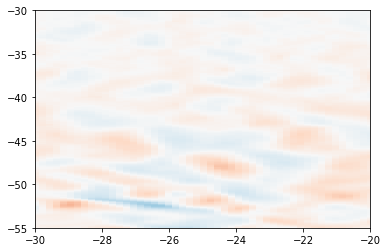

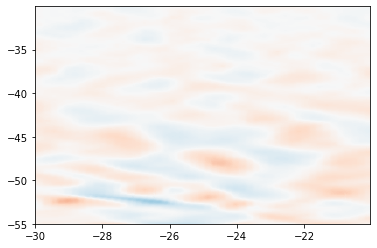

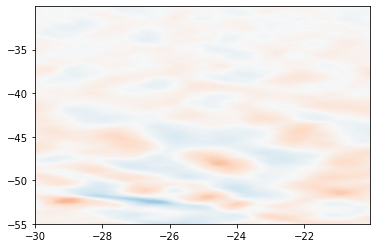

In [16]:
plt.pcolormesh(lons,lats,var_mean,cmap='RdBu_r',vmin=-1,vmax=1)
plt.ylim(y0,y1);plt.xlim(x0,x1)
plt.figure()
plt.pcolormesh(mx,my,idw_eta,cmap='RdBu_r',vmin=-1,vmax=1)
plt.figure()
plt.pcolormesh(mx,my,rbf_eta,cmap='RdBu_r',vmin=-1,vmax=1)

In [17]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p.df['time']
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df = pa.degs2ms(df)
df = df.persist()

In [79]:
lon,lat = df.lon.values.compute(),df.lat.values.compute()

In [34]:
lon_max,lon_min = lons.values.max(),lons.values.min()
lat_max,lat_min = lats.values.max(),lats.values.min()

In [36]:
lon_max

51.802082

In [38]:
df[np.where(df.lon<=lon_max)[0]]

KeyboardInterrupt: 

In [89]:
np.where(lat[np.where(lon>-30)[0]]<-30)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


(array([   101370,    101371,    101372, ..., 345701944, 345701945,
        345701946]),)

In [92]:
np.where(lon>-30)[0][101370]

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


15392801

In [94]:
lon[15392801]

-29.65625

In [98]:
df.trajectory.values.compute()[15392801]

4000125

In [19]:
df_tst = df.groupby('trajectory').get_group(4000125).compute()
#df.where(df.index>=49001834)#.compute()

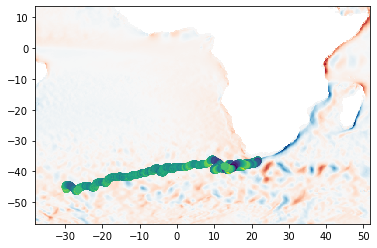

In [21]:
plt.pcolormesh(lons,lats,var_mean,cmap='RdBu_r',vmin=-1,vmax=1)
#plt.ylim(y0,y1);plt.xlim(x0,x1)
plt.scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity)

In [22]:
#x0, x1 = -30, -20
#y0, y1 = -55, -30
#res = 1 / 32.0
mx_tst, my_tst = np.meshgrid(df_tst.lon,
                        df_tst.lat,
                        indexing="ij")

In [23]:
idw_eta, neighbors = mesh.inverse_distance_weighting(
    np.vstack((mx_tst.flatten(), my_tst.flatten())).T,
    within=True,  # Extrapolation is forbidden
    radius=55000,  # In a radius of 5.5 Km
    k=8,  # We are looking for at most 8 neighbours
    num_threads=0)
idw_eta = idw_eta.reshape(mx_tst.shape)

In [115]:

print(idw_eta.size,df_tst.lat.size)

87609600 9360


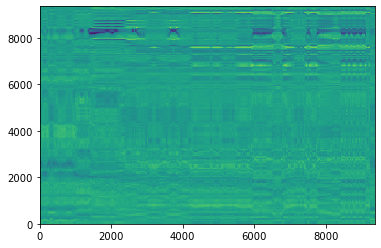

In [117]:
plt.pcolormesh(idw_eta)

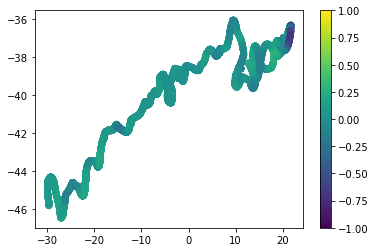

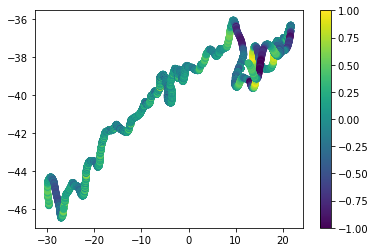

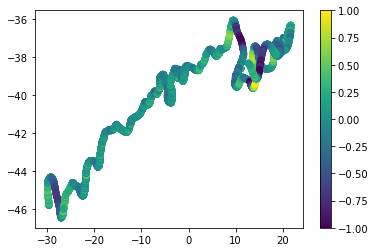

In [27]:
cs = plt.scatter(df_tst.lon,df_tst.lat,c=np.diag(idw_eta),vmin=-1,vmax=1)
plt.colorbar(cs)
plt.figure()
cs2 = plt.scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity,vmin=-1,vmax=1)
plt.colorbar(cs2)

plt.figure()
plt.scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity-np.diag(idw_eta),vmin=-1,vmax=1)
plt.colorbar()

In [39]:
cluster.close()